In [ ]:
import torch
import torch.nn as nn
import math

class RotaryPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len: int = 512):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # say d_model=8
        # [0, 2, 4, 6, 8]
        position_indices = torch.arange(0, d_model, 2).float()
        # [0, 2/8, 4/8, 6/8, 1] 
        freq_indices = position_indices / d_model
        # [1, 10, 100, 1000]
        inv_freq = 10000 ** freq_indices
        # [1,    slowest rotation 
        # 0.1,   slower rotation
        # 0.01,  faster rotation
        # 0.001] fastest rotation
        inv_freq = 1.0 / inv_freq
        self.register_buffer("inv_freq", inv_freq)
    
    def forward(self, hidden_states, seq_len=None):
        if seq_len is None:
            seq_len = hidden_states.shape[1]
        
        positions = torch.arange(seq_len, device=hidden_states.device).float()

        angles = positions.unsqueeze(1) * self.inv_freq.unsqueeze(0)

        cos = torch.cos(angles)
        sin = torch.sin(angles)

        return cos, sin

In [6]:
def apply_rotary_embedding(q, k, cos, sin):
    q_real, q_fake = q[..., ::2], q[..., 1::2]
    k_real, k_fake = k[..., ::2], k[..., 1::2]

    # Apply rotation
    q_out_real = q_real * cos - q_fake * sin
    q_out_fake = q_real * sin + q_fake * cos

    k_out_real = k_real * cos - k_fake * sin
    k_out_fake = k_real * sin - k_fake * cos

    # Interleave real and fake parts
    q_out = torch.stack([q_out_real, q_out_fake], dim=-1).flatten(-2)
    k_out = torch.stack([k_out_real, k_out_fake], dim=-1).flatten(-2)
    
    return q_out, k_out

In [ ]:
def rope_example():
    batch_size = 2
    seq_len = 4
    d_model = 8

    q = torch.randn(batch_size, seq_len, d_model)
    k = torch.randn(batch_size, seq_len, d_model)

    rope = RotaryPositionalEncoding(d_model)
    cos, sin = rope(q)

    q_rotated, k_rotated = apply_rotary_embedding(q, k, cos, sin)

    print("Original shapes:")
    print(f"Query shape: {q.shape}")
    print(f"Key shape: {k.shape}")
    print(f"\nRotated shapes:")
    print(f"Query shape: {q_rotated.shape}")
    print(f"Key shape: {k_rotated.shape}")

    print(f"\nPosition encoding effect (pos 0 - slowest, pos last fastest):")
    positions = torch.arange(seq_len)
    for pos in positions:
        original_vec = q[0, pos, :4]
        rotated_vec = q_rotated[0, pos, :4]
        print(f"\nPoisiton {pos}:")
        print(f"Original: {original_vec}")
        print(f"Rotated: {rotated_vec}")
        
rope_example()

Original shapes:
Query shape: torch.Size([2, 4, 8])
Key shape: torch.Size([2, 4, 8])

Rotated shapes:
Query shape: torch.Size([2, 4, 8])
Key shape: torch.Size([2, 4, 8])

Position encoding effect (pos 0 - slowest, pos last fastest):

Poisiton 0:
Original: tensor([-0.5837, -0.1903,  0.7715,  0.1845])
Rotated: tensor([-0.5837, -0.1903,  0.7715,  0.1845])

Poisiton 1:
Original: tensor([ 0.2183, -1.1813,  0.6155,  0.9850])
Rotated: tensor([ 1.1120, -0.4546,  0.5141,  1.0415])

Poisiton 2:
Original: tensor([-1.0390, -0.7576,  0.2188,  0.1384])
Rotated: tensor([ 1.1212, -0.6295,  0.1869,  0.1791])

Poisiton 3:
Original: tensor([-1.2460,  0.9339, -1.4440,  0.0736])
Rotated: tensor([ 1.1017, -1.1004, -1.4012, -0.3564])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_rope_effect(do_print=False):
    batch_size = 2
    seq_len = 4
    d_model = 8

    q = torch.randn(batch_size, seq_len, d_model)
    k = torch.randn(batch_size, seq_len, d_model)

    rope = RotaryPositionalEncoding(d_model)

    cos, sin = rope(q)

    q_rotated, k_rotated = apply_rotary_embedding(q, k, cos, sin)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("RoPE Effects Across Positions", fontsize=16)
    
    # first batch
    q = q[0]
    q_rotated = q_rotated[0]

    for pos in range(seq_len):
        ax = axes[pos//2, pos%2]
        
        original = q[pos].detach().numpy()
        rotated = q_rotated[pos].detach().numpy()

        x = np.arange(d_model)
        width = 0.35

        ax.bar(x-width/2, original, width, label="Original", alpha=0.6)
        ax.bar(x+width/2, rotated, width, label="Rotated", alpha=0.6)

        ax.set_title(f"Position {pos}")
        ax.set_xlabel("Dimension")
        ax.set_ylabel("Value")
        ax.legend()

        ax.grid(True, alpha=0.3)

        for i in range(0, d_model, 2):
            ax.axvspan(i-0.25, i+1.25, color="gray", alpha=0.1)
        
        if do_print:
            print(f"Position {pos}")
            print(f"Original tensor({original.tolist()})")
            print(f"Rotated tensor({rotated.tolist()})")
    
    plt.tight_layout()

    fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))
    for pair in range(d_model//2):
        ax = axes2[pair//2, pair%2]

        orig_real = q[:, pair*2].detach().numpy()
        orig_fake = q[:, pair*2+1].detach().numpy()

        rot_real = q_rotated[:, pair*2].detach().numpy()
        rot_fake = q_rotated[:, pair*2+1].detach().numpy() 

        ax.scatter(orig_real, orig_fake, c="blue", label="Original")
        ax.scatter(rot_real, rot_fake, c="red", label="Rotated")

        for i in range(seq_len):
            ax.plot([orig_real[i], rot_real[i]], [orig_fake[i], rot_fake[i]], "gray", alpha=0.3)
            ax.annotate(f"Pos {i}", (orig_real[i], orig_fake[i]))
            ax.annotate(f"Pos {i}", (rot_real[i], rot_fake[i]))
        
        ax.set_title(f"Dimension Pair {pair}")
        ax.set_xlabel("Real Part")
        ax.set_ylabel("Fake Part")
        ax.grid(True)
        ax.legend()
        ax.set_aspect("equal")
    plt.tight_layout()

    return fig, fig2

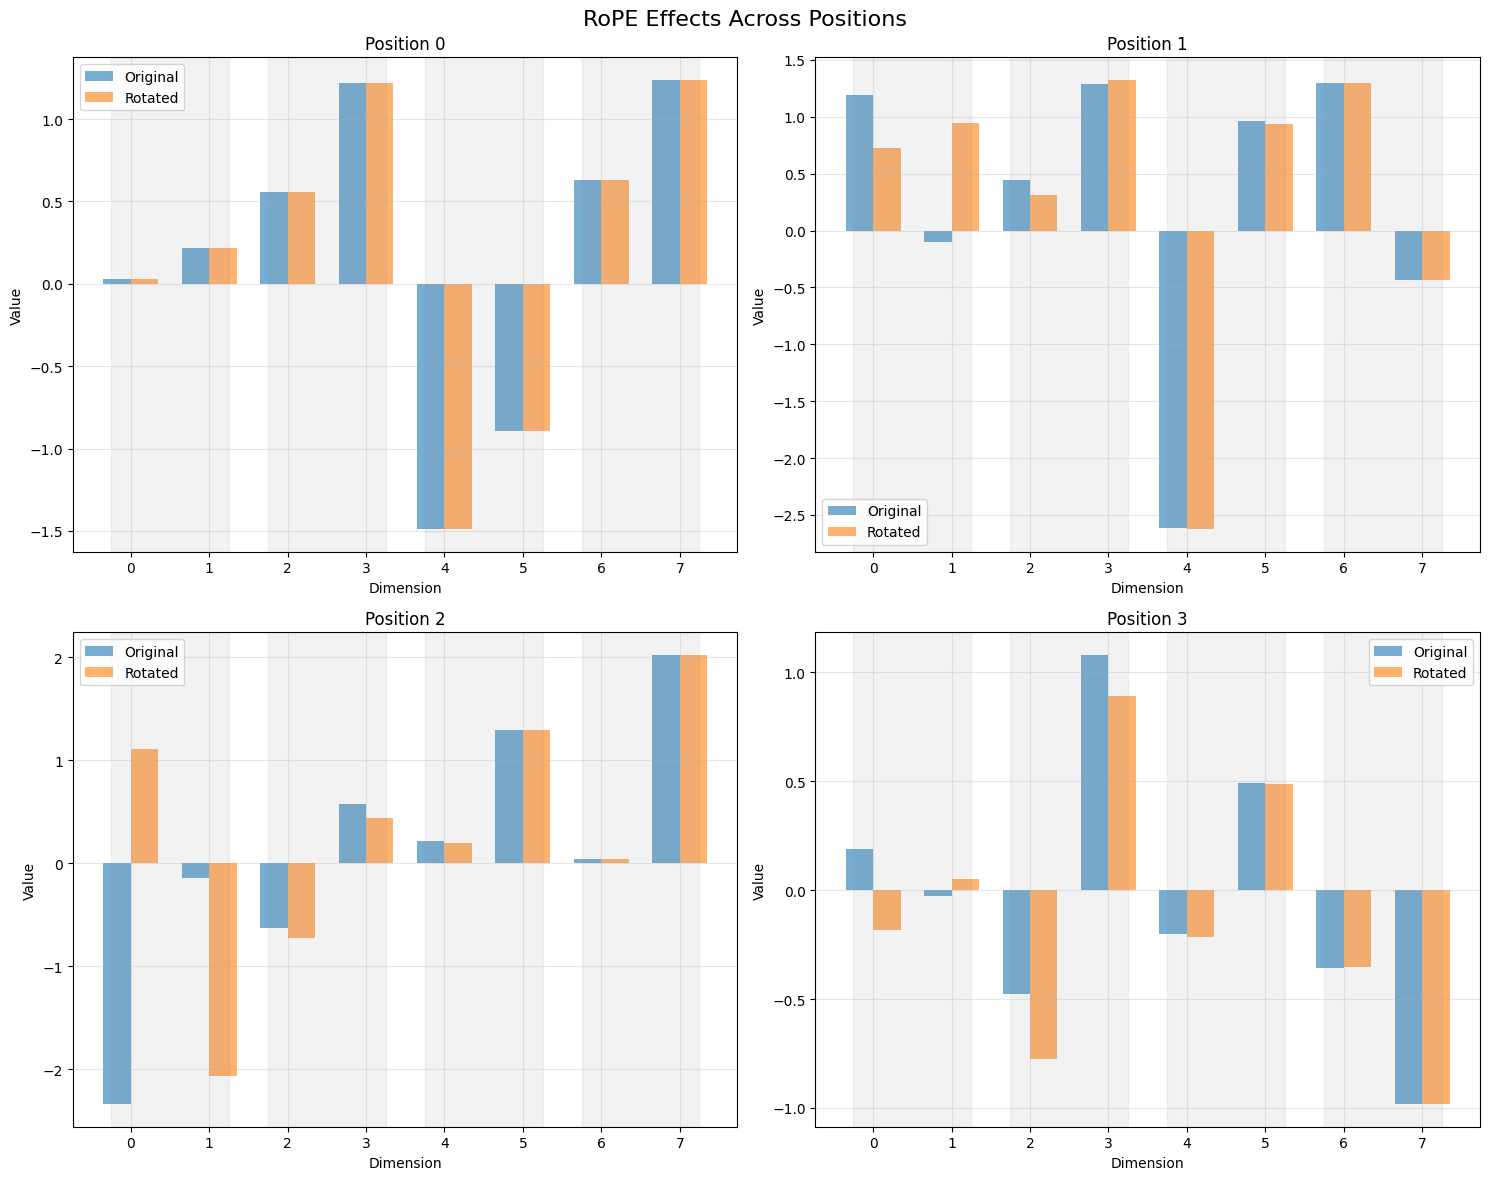

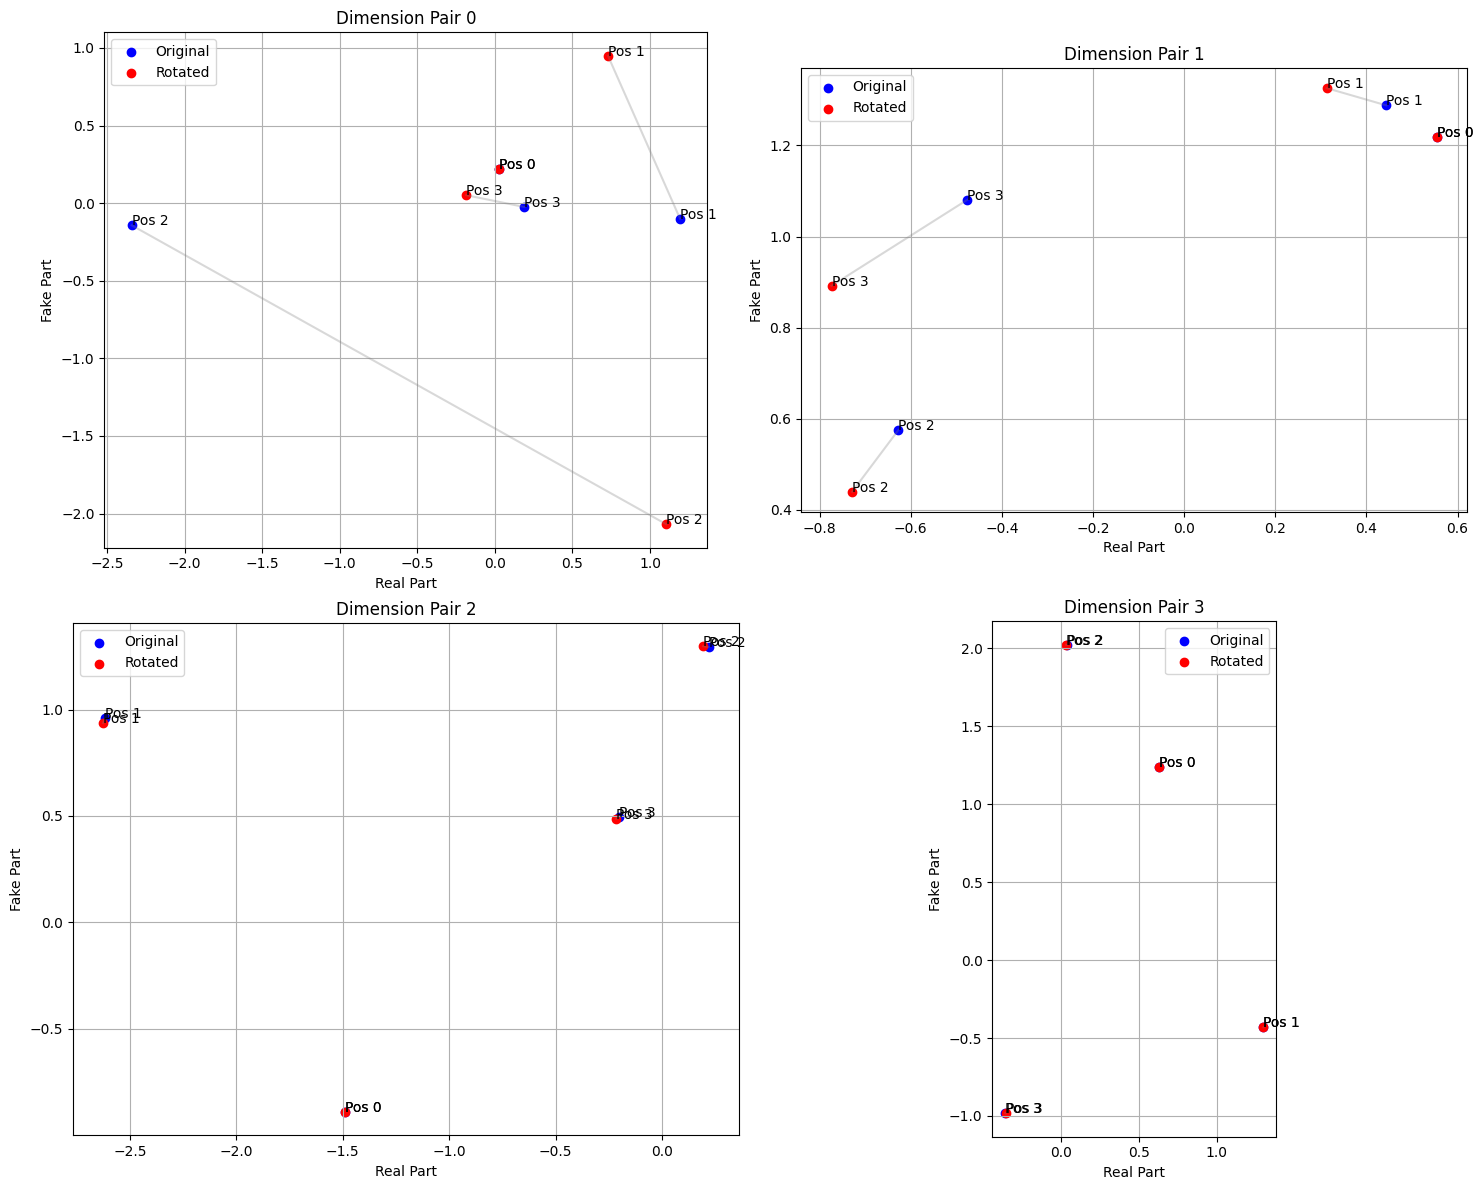

In [14]:
fig1, fig2 = visualize_rope_effect()
plt.show()